# Ensembles
Lecture recap
1. Combine many weak algorithms into one strong
2. Most of them use decision trees as base estimators - they are fast, invariant to scaling, and handle well features of different nature
3. For problems like the one about Higgs (small number of features of different origin) state-of-the is ensembles of decision trees.

## RandomForest
1. Uses random subspace method on Decision Trees
2. Isn't prone to overfitting
3. Easily parallelized

## Boosting
1. Ensemble members are trained consequently to compensate for imperfection
2. Will overfit, especially if strong base algorithms are used
3. Can be parallelized (Google is your friend)

## Bagging over KNN over Higgs data

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import root_pandas
from sklearn.cross_validation import cross_val_score
from sklearn.ensemble import BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier

In [3]:
high_level_features = ['m_jj', 'm_jjj', 'm_jlv', 'm_wwbb', 'm_bb', 'm_wbb', 'm_lv']
training_data = root_pandas.read_root(
    "/notebooks/public_train_10000.root", columns=high_level_features + ["target",])

In [12]:
knn_cv = cross_val_score(KNeighborsClassifier(),
                training_data[high_level_features],
                training_data["target"],
                cv=4, n_jobs=4, scoring="roc_auc")
print knn_cv.mean(), knn_cv.std()

0.705906863774 0.00224599292916


In [14]:
bagging_cv = cross_val_score(BaggingClassifier(base_estimator=KNeighborsClassifier(), n_jobs=4),
                             training_data[high_level_features],
                             training_data["target"], scoring='roc_auc', cv=4)
print bagging_cv.mean(), bagging_cv.std()

0.713713306841 0.00156703470692


Free prediction power improvement this is.

# RandomForest
Let's see how decision surface for ReandomForest changes with incerase in the number of estimators.

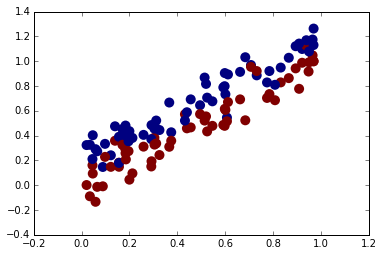

In [18]:
np.random.seed(42)
x_space = np.random.uniform(0, 1, size=60)
y0 = x_space + 0.2 + np.random.normal(size=len(x_space), scale=0.1)
y1 = x_space + np.random.normal(size=len(x_space), scale=0.1)
shuffle = np.random.permutation(2*len(x_space))
line_features = np.concatenate((np.concatenate((x_space, x_space))[:, np.newaxis],
                          np.concatenate((y0, y1))[:, np.newaxis]), axis=1)[shuffle]
line_labels = np.concatenate((np.zeros(len(y0)), np.ones(len(y1))))[shuffle]
fig, ax = plt.subplots()
ax.scatter(line_features[:, 0], line_features[:, 1], c=line_labels, edgecolors='none', s=100)

In [19]:
n_classes = 2
plot_colors = "bry"
plot_step = 0.02
from sklearn.preprocessing import scale
def plot_decision_on_axes(clf, ax, features, labels):
    X = scale(features)
    X = features
    clf.fit(X, labels)
    
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    cs = ax.contourf(xx, yy, Z, cmap=plt.cm.Paired)

    plt.axis("tight")

    # Plot the training points
    for i, color in zip(range(n_classes), plot_colors):
        idx = np.where(labels == i)
        ax.scatter(X[idx, 0], X[idx, 1], c=color, cmap=plt.cm.Paired)

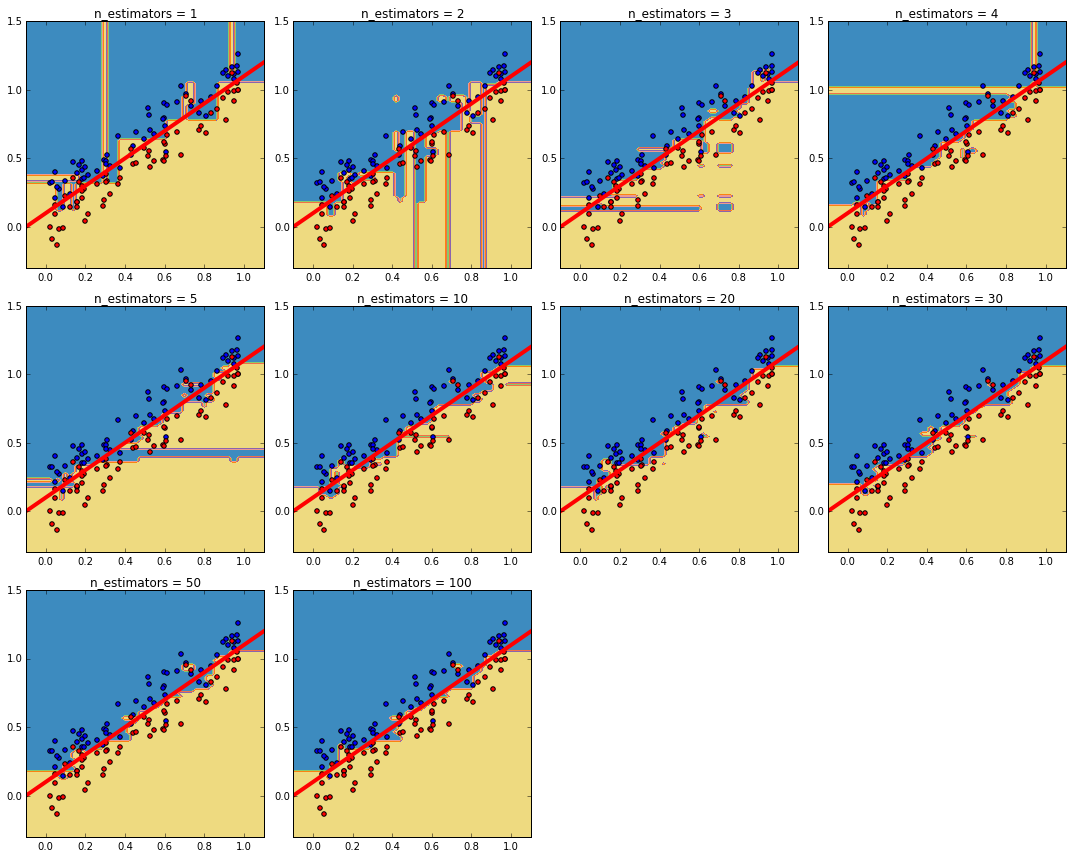

In [17]:
from sklearn.ensemble import RandomForestClassifier
estimators_set = (1, 2, 3, 4, 5, 10, 20, 30, 50, 100)
screen_width, plot_height = 15, 4
n_rows = 3
n_cols = np.ceil(np.true_divide(len(estimators_set), n_rows))
fig = plt.figure(figsize=(screen_width, plot_height*n_rows))
x_range = np.linspace(-0.1, 1.1, num=100)
y_true = x_range + 0.1
for i, n_estimators in enumerate(estimators_set):
    clf = RandomForestClassifier(n_jobs=-1, n_estimators=n_estimators)
    ax = fig.add_subplot(n_rows, n_cols, i+1)
    plot_decision_on_axes(clf, ax, line_features, line_labels)
    ax.set_title("n_estimators = %d" % n_estimators)
    ax.plot(x_range, y_true, 'r', lw=4)
    ax.set_xlim((-0.1, 1.1))
    ax.set_ylim((-0.3, 1.5))
plt.tight_layout()

Takeaway: in most cases you can improve any classifier with bagging.

## Boosting for COMET data

In [23]:
from rep.estimators import XGBoostClassifier # Use wrapper from Yandex REP (Alexey and Tatiana)

In [32]:
# XGBoostClassifier is parrallel inside
xgboost_cv = cross_val_score(XGBoostClassifier(),
                             training_data[high_level_features].astype(np.float64),
                             training_data["target"].astype(np.int64), cv=4)
print(xgboost_cv.mean(), xgboost_cv.std())

(0.66730097342415573, 0.0059342570477801237)


Less than KNN... But what if try on all features?

In [35]:
training_data_all_columns = root_pandas.read_root("/notebooks/public_train_10000.root").astype(np.float64)

In [39]:
features = training_data_all_columns[list(set(training_data_all_columns ) - {"target", "event_id"})]
target = training_data_all_columns.target.astype(np.bool)

In [42]:
knn_cv_on_full = cross_val_score(KNeighborsClassifier(), features, target, cv=4, n_jobs=4)
print(knn_cv_on_full.mean(), knn_cv_on_full.std())

(0.65030157235225161, 0.0070247093035029021)


In [44]:
knn_cv_canberra = cross_val_score(KNeighborsClassifier(metric="canberra"), features, target, cv=4, n_jobs=4)
print(knn_cv_canberra.mean(), knn_cv_canberra.std())

(0.55860060483209673, 0.0027955233995546874)


Such an awfull quality drop... Have any ideas why?

In [46]:
xgb_cv_full = cross_val_score(XGBoostClassifier(), features, target, cv=4)
print(xgb_cv_full.mean(), xgb_cv_full.std())

(0.67919961470393841, 0.0052451995780616696)


A bit better than XGB on the high level features, but still worse than KNN

**Exercise 0** Plot learning curve for the KNN and XGBoost. A Learning curve is performance dependace on the size of the training dataset. Learning curve is useful when selecting a dataset size for experimentation as time grows with the dataset size.
1. http://scikit-learn.org/stable/modules/generated/sklearn.learning_curve.validation_curve.html#sklearn.learning_curve.validation_curve
2. Bonus points for plotting errors, for example with http://matplotlib.org/api/axes_api.html#matplotlib.axes.Axes.fill_between